In [1]:
%matplotlib inline
import os
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import utils
import librosa
import librosa.display
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_excel(r'./dataset.xlsx')
df = df.set_index(df.iloc[:,0].name)

## Decision Tree Electronic

In [3]:
def report(results, n_top=3):
    md = []
    ms = []
    ml = []
    cr = []
    mean = []
    std = []
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            mean.append( results['mean_test_score'][candidate])
            std.append(results['std_test_score'][candidate])
            ms.append(random_search.cv_results_['params'][candidate]['min_samples_split'])
            ml.append(random_search.cv_results_['params'][candidate]['min_samples_leaf'])
            cr.append(random_search.cv_results_['params'][candidate]['criterion'])
            md.append(random_search.cv_results_['params'][candidate]['max_depth'])
    dres = pd.DataFrame()
    dres['Mean Test Score'] = mean
    dres['Standard Deviation Test Score'] = std
    dres['Min Sample Leaf'] = ml
    dres['Min Sample Split'] = ms
    dres['Criterion'] = cr
    dres['Max Depth'] = md
    return dres

def report_verbose(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Model with rank: {0}".format(i))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [4]:
attributes = [col for col in df.columns if col != 'Electronic labeler']
X = df[attributes].values
y = df['Electronic labeler']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [5]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(8728, 19)
(3741, 19)
(8728,)
(3741,)


In [6]:
param_list = {'max_depth': [None] + list(np.arange(2, 50)),
              'min_samples_split': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150,160,170,180,190,200],
              'min_samples_leaf': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150,160,170,180,190,200],
              'criterion': ['gini', 'entropy'],
             }

dtc = DecisionTreeClassifier()
skf = RepeatedStratifiedKFold(n_splits=10, random_state=123)

cvs = []
results = []

random_search = RandomizedSearchCV(dtc, param_distributions=param_list, n_iter=50, cv = 5)

random_search.fit(X, y)
dres = pd.DataFrame
dres = report(random_search.cv_results_, n_top=20).copy()
report_verbose(random_search.cv_results_, n_top=2)

Model with rank: 1
Mean validation score: 0.797 (std: 0.014)
Model with rank: 1
Parameters: {'min_samples_split': 60, 'min_samples_leaf': 110, 'max_depth': 43, 'criterion': 'entropy'}

Model with rank: 2
Mean validation score: 0.796 (std: 0.011)
Model with rank: 2
Parameters: {'min_samples_split': 170, 'min_samples_leaf': 80, 'max_depth': 40, 'criterion': 'entropy'}

Model with rank: 2
Mean validation score: 0.796 (std: 0.011)
Model with rank: 2
Parameters: {'min_samples_split': 140, 'min_samples_leaf': 80, 'max_depth': 10, 'criterion': 'entropy'}

Model with rank: 2
Mean validation score: 0.796 (std: 0.011)
Model with rank: 2
Parameters: {'min_samples_split': 160, 'min_samples_leaf': 80, 'max_depth': 21, 'criterion': 'entropy'}

Model with rank: 2
Mean validation score: 0.796 (std: 0.011)
Model with rank: 2
Parameters: {'min_samples_split': 80, 'min_samples_leaf': 80, 'max_depth': 31, 'criterion': 'entropy'}



In [7]:
#parametri migliori
dres.sort_values(by='Mean Test Score' , ascending = False).head(3)

,Mean Test Score,Standard Deviation Test Score,Min Sample Leaf,Min Sample Split,Criterion,Max Depth
0,0.797496,0.014232,110,60,entropy,43.0
2,0.795973,0.011266,80,140,entropy,10.0
3,0.795973,0.011266,80,160,entropy,21.0


In [8]:
print(random_search.best_estimator_)
dtc = random_search.best_estimator_
dtc = dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
y_pred_tr = dtc.predict(X_train)

DecisionTreeClassifier(criterion='entropy', max_depth=43, min_samples_leaf=110,
                       min_samples_split=60)


In [9]:
for col, imp in zip(attributes, dtc.feature_importances_):
    print(col, imp)

acousticness 0.10931950509520766
danceability 0.3766950733517515
energy 0.04966265823467745
instrumentalness 0.15880072549502114
liveness 0.0
speechiness 0.08993152234100626
tempo 0.019468864642559976
valence 0.051003381960287676
mfcc_mean 0.0
chroma_cens_mean 0.023303174810256927
chroma_cqt_mean 0.005000268598997313
chroma_stft_mean 0.0
tonnetz_mean 0.0049734768632632214
spectral_contrast_mean 0.017566131848248137
spectral_centroid_mean 0.0
spectral_bandwidth_mean 0.08712488715865456
spectral_rolloff_mean 0.0
rmse_mean 0.0035869075126893964
zcr_mean 0.0035634220873787268


Text(0.5, 0, 'Importance')

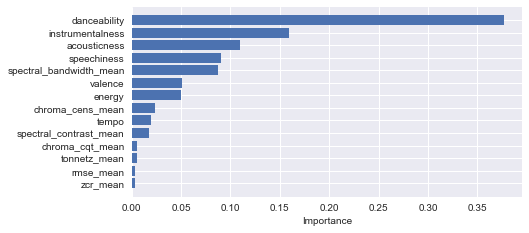

In [10]:
plt.figure(figsize=(7, 3.5))
plt.style.use('seaborn')
feature = pd.DataFrame({'Feature_name': attributes, 'Importances' : dtc.feature_importances_})
feature = feature.sort_values('Importances' , ascending = True)
feature = feature[feature['Importances'] > 0.0]
plt.barh (feature['Feature_name'] , feature['Importances'])
plt.xlabel("Importance", size=10)
#plt.ylabel("Feature", size=18)
#plt.title("Decision Tree feature importances", size=21)

[Text(4650.0, 2378.25, 'danceability <= 0.62\nentropy = 0.807\nsamples = 8728\nvalue = [6570, 2158]\nclass = No Electronic'),
 Text(2325.0, 1849.75, 'spectral_bandwidth_mean <= 1826.266\nentropy = 0.647\nsamples = 6390\nvalue = [5334, 1056]\nclass = No Electronic'),
 Text(1162.5, 1321.25, 'valence <= 0.106\nentropy = 0.573\nsamples = 5521\nvalue = [4771, 750]\nclass = No Electronic'),
 Text(581.25, 792.75, 'danceability <= 0.459\nentropy = 0.796\nsamples = 919\nvalue = [698, 221]\nclass = No Electronic'),
 Text(290.625, 264.25, '\n  (...)  \n'),
 Text(871.875, 264.25, '\n  (...)  \n'),
 Text(1743.75, 792.75, 'danceability <= 0.442\nentropy = 0.515\nsamples = 4602\nvalue = [4073, 529]\nclass = No Electronic'),
 Text(1453.125, 264.25, '\n  (...)  \n'),
 Text(2034.375, 264.25, '\n  (...)  \n'),
 Text(3487.5, 1321.25, 'instrumentalness <= 0.178\nentropy = 0.936\nsamples = 869\nvalue = [563, 306]\nclass = No Electronic'),
 Text(2906.25, 792.75, 'danceability <= 0.507\nentropy = 0.759\nsampl

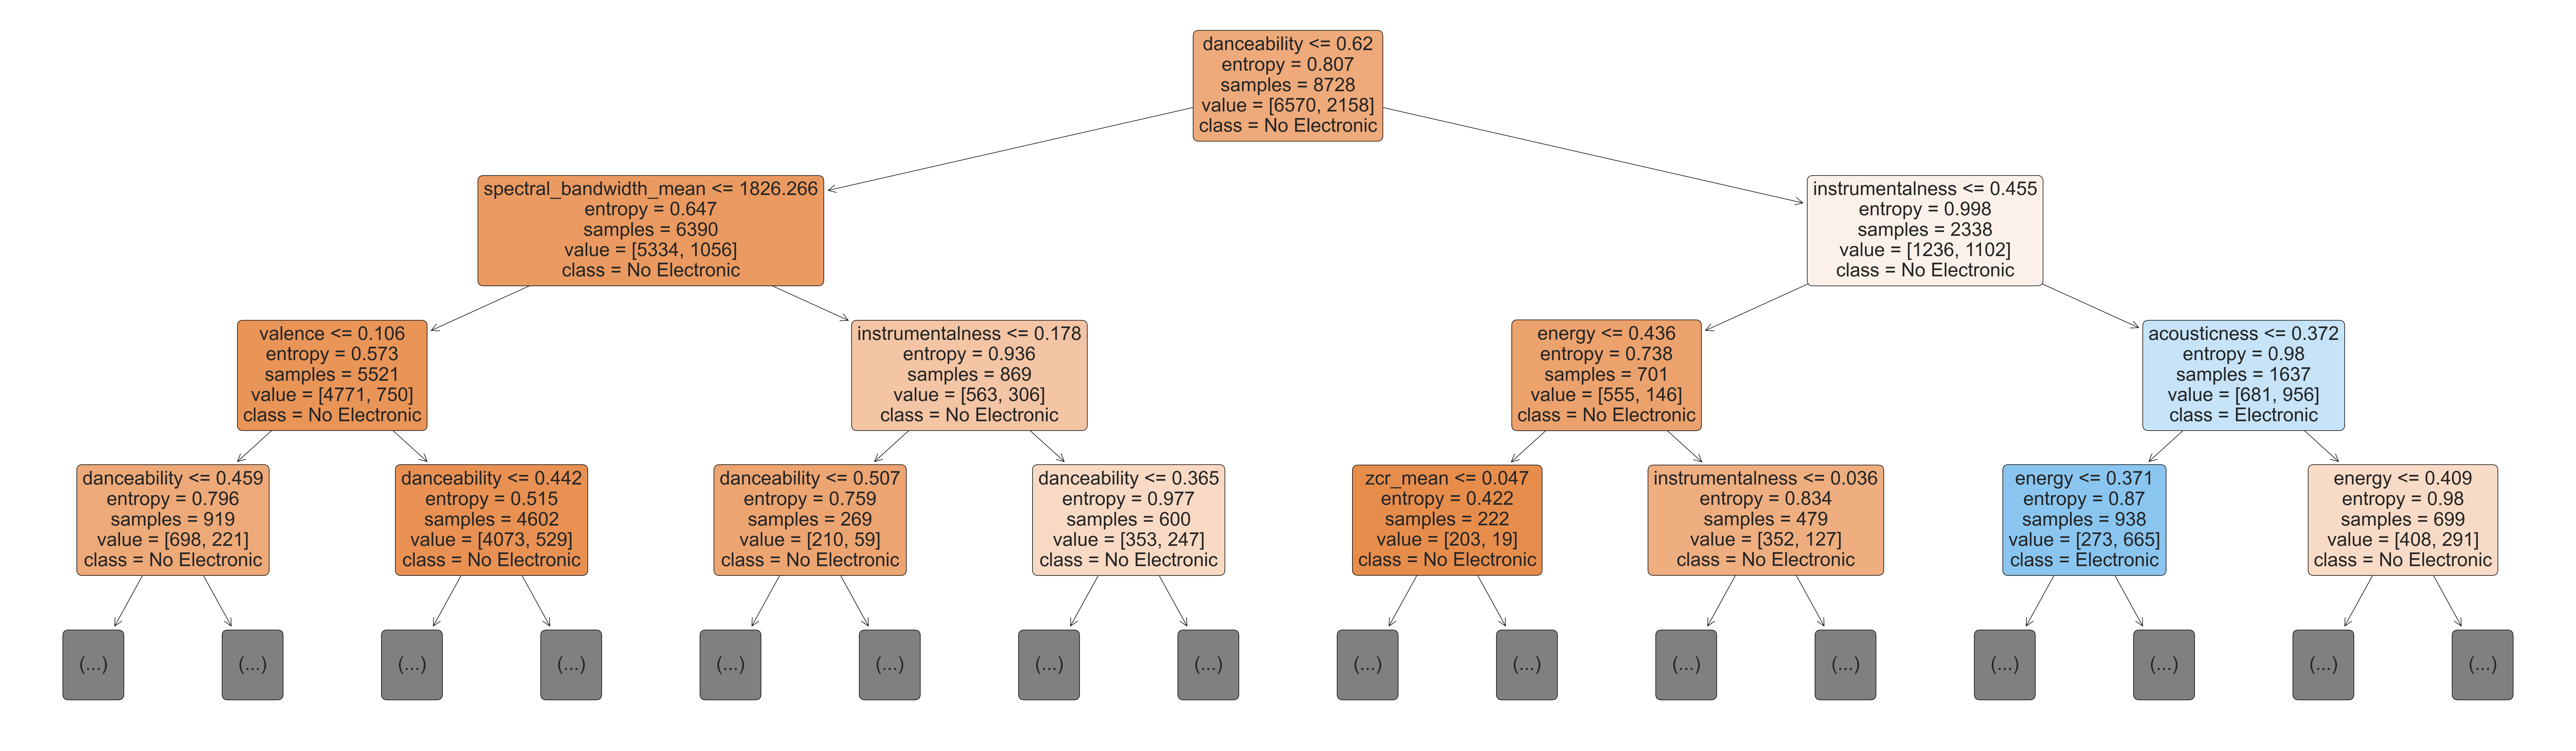

In [11]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (24,7), dpi=500)
sklearn.tree.plot_tree(dtc,feature_names=attributes,
                        class_names=['Electronic' if x == 1 else 'No Electronic' for x in dtc.classes_],  
                        filled=True, rounded=True,
                        label = 'all' , max_depth = 3, fontsize = 10)

In [12]:
y_pred_tr = dtc.predict(X_train)

print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average=None))

print(classification_report(y_train, y_pred_tr))

confusion_matrix(y_train, y_pred_tr)

Train Accuracy 0.8173693858845096
Train F1-score [0.88522465 0.55325112]
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      6570
           1       0.70      0.46      0.55      2158

    accuracy                           0.82      8728
   macro avg       0.77      0.70      0.72      8728
weighted avg       0.81      0.82      0.80      8728



array([[6147,  423],
       [1171,  987]])

In [13]:
y_pred = dtc.predict(X_test)
print('Train Accuracy %s' % accuracy_score(y_test, y_pred))
print('Train F1-score %s' % f1_score(y_test, y_pred, average=None))
print()
print(classification_report(y_test, y_pred))

confusion_matrix(y_test, y_pred)

Train Accuracy 0.7939053728949479
Train F1-score [0.87078934 0.49108911]

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      2816
           1       0.63      0.40      0.49       925

    accuracy                           0.79      3741
   macro avg       0.73      0.66      0.68      3741
weighted avg       0.78      0.79      0.78      3741



array([[2598,  218],
       [ 553,  372]])

In [14]:
# evaluate predictions
print(X_train.shape, y_train.shape)
mae = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % mae)

(8728, 19) (8728,)
MAE: 0.206


In [15]:
dtc = random_search.best_estimator_
dtc = dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
y_pred_tr = dtc.predict(X_train)

fpr1, tpr1, _ = roc_curve(y_test, y_pred)
roc_auc1 = auc(fpr1, tpr1)
print(roc_auc1)

roc_auc1 = roc_auc_score(y_test, y_pred)

0.6623736947174447


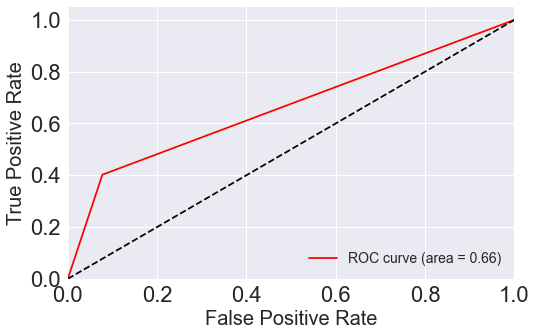

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(fpr1, tpr1, label='ROC curve (area = %0.2f)' % (roc_auc1), c = 'r')
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0],)
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

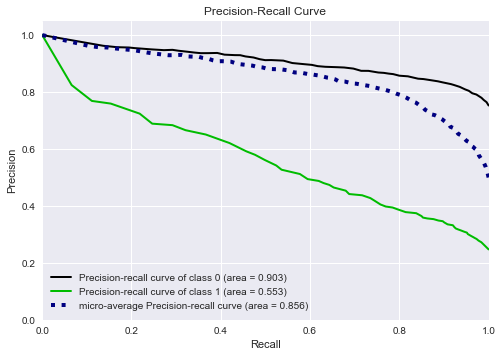

In [17]:
y_score = dtc.predict_proba(X_test)

plot_precision_recall(y_test, y_score)
plt.show()

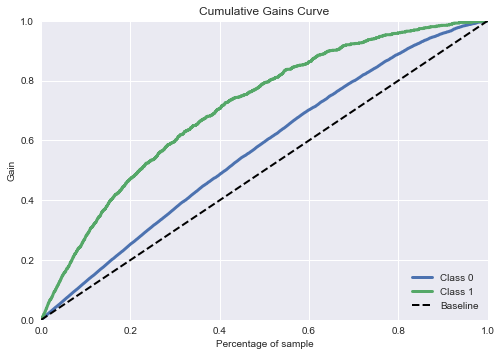

In [18]:
plot_cumulative_gain(y_test, y_score)
plt.show()

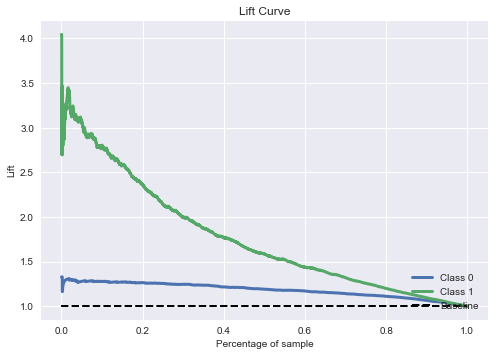

In [19]:
plot_lift_curve(y_test, y_score)
plt.show()

## KNN Electronic

In [20]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

df[['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence', 'mfcc_mean',
       'chroma_cens_mean', 'chroma_cqt_mean', 'chroma_stft_mean',
       'tonnetz_mean', 'spectral_contrast_mean', 'spectral_centroid_mean',
       'spectral_bandwidth_mean', 'spectral_rolloff_mean', 'rmse_mean',
       'zcr_mean']] = scaler.fit_transform(df[['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence', 'mfcc_mean',
       'chroma_cens_mean', 'chroma_cqt_mean', 'chroma_stft_mean',
       'tonnetz_mean', 'spectral_contrast_mean', 'spectral_centroid_mean',
       'spectral_bandwidth_mean', 'spectral_rolloff_mean', 'rmse_mean',
       'zcr_mean']])

df.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,mfcc_mean,chroma_cens_mean,chroma_cqt_mean,chroma_stft_mean,tonnetz_mean,spectral_contrast_mean,spectral_centroid_mean,spectral_bandwidth_mean,spectral_rolloff_mean,rmse_mean,zcr_mean,Electronic labeler
track_id,,,,,,,,,,,,,,,,,,,,
2,-0.288519,0.982312,0.349387,-1.744299,-0.046462,0.482131,1.266050,0.490339,-0.438488,0.667869,0.652836,-0.552811,1.206044,-0.025942,1.036232,0.398672,0.847513,-0.552881,1.534804,0
3,-0.399234,0.207262,1.017482,-1.768594,-0.510031,2.777503,0.123731,-0.627530,0.199917,1.069189,1.086740,0.379882,0.235017,-0.024231,1.334086,0.730280,1.107144,-0.363652,1.486685,0
5,-1.265834,1.349028,0.593988,-1.771789,1.216329,0.218723,-0.658933,0.653973,0.004753,0.985098,0.858930,-0.351168,-0.577659,-0.023659,0.199770,0.156518,0.327997,-0.524571,0.046049,0
10,1.112839,0.889068,1.408383,0.898637,-0.448060,-0.476397,-0.327597,1.897323,0.010304,1.279819,1.670373,0.109657,-1.372757,-0.220586,0.361622,-0.080773,0.148707,-0.234162,1.163252,0
134,-0.195421,0.126178,0.078964,-1.719900,-0.570189,3.260855,-0.247622,1.644537,-0.071229,0.562875,0.855864,0.150201,-0.574985,-0.410579,0.114678,-0.350417,0.000517,-0.497763,0.561394,0


In [21]:
attributes = [col for col in df.columns if col != 'Electronic labeler']
X = df[attributes].values
y = df['Electronic labeler']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

In [22]:
param_list = {
    'n_neighbors' : list(range(1, 30)),
    'algorithm': ['ball_tree', 'kd_tree','brute'],
    'weights': ['distance','uniform'],
    'leaf_size' : list(range(1, 150)),
    'metric' : ['euclidean' , 'cosine', 'minkowski']
}

knn = KNeighborsClassifier()

random_search = RandomizedSearchCV(knn,param_distributions=param_list, n_iter=50, cv = 5)
random_search.fit(X, y)
report_verbose(random_search.cv_results_, n_top=3)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 1157, in fit
    return self._fit(X)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 350, in _fit
    self._check_algorithm_metric()
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 332, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'cosine' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['kd_tree']) to get valid options. Metric can also be a callable function.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 1157, in fit
    return self._fit(X)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 350, in _fit
    self._check_algorithm_metric()
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 332, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'cosine' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['ball_tree']) to get valid options. Metric can also be a callable functio

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 1157, in fit
    return self._fit(X)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 350, in _fit
    self._check_algorithm_metric()
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 332, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'cosine' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['ball_tree']) to get valid options. Metric can also be a callable functio

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 1157, in fit
    return self._fit(X)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 350, in _fit
    self._check_algorithm_metric()
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 332, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'cosine' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['ball_tree']) to get valid options. Metric can also be a callable functio

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 1157, in fit
    return self._fit(X)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 350, in _fit
    self._check_algorithm_metric()
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 332, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'cosine' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['kd_tree']) to get valid options. Metric can also be a callable function.

Model with rank: 1
Mean validation score: 0.798 (std: 0.010)
Model with rank: 1
Parameters: {'weights': 'distance', 'n_neighbors': 22, 'metric': 'minkowski', 'leaf_size': 101, 'algorithm': 'ball_tree'}

Model with rank: 2
Mean validation score: 0.798 (std: 0.010)
Model with rank: 2
Parameters: {'weights': 'distance', 'n_neighbors': 20, 'metric': 'euclidean', 'leaf_size': 123, 'algorithm': 'ball_tree'}

Model with rank: 3
Mean validation score: 0.798 (std: 0.010)
Model with rank: 3
Parameters: {'weights': 'uniform', 'n_neighbors': 21, 'metric': 'minkowski', 'leaf_size': 83, 'algorithm': 'brute'}

Model with rank: 3
Mean validation score: 0.798 (std: 0.010)
Model with rank: 3
Parameters: {'weights': 'uniform', 'n_neighbors': 21, 'metric': 'minkowski', 'leaf_size': 123, 'algorithm': 'kd_tree'}



In [23]:
clf = random_search.best_estimator_
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_tr = clf.predict(X_train)

In [24]:
print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average=None))

print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

Train Accuracy 1.0
Train F1-score [1. 1.]
Test Accuracy 0.8116646415552855
Test F1-score [0.88406881 0.49838188]
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      3098
           1       0.73      0.38      0.50      1017

    accuracy                           0.81      4115
   macro avg       0.78      0.67      0.69      4115
weighted avg       0.80      0.81      0.79      4115



array([[2955,  143],
       [ 632,  385]])

In [25]:
fpr3, tpr3, _ = roc_curve(y_test, y_pred)
roc_auc3 = auc(fpr3, tpr3)
print(roc_auc3)

roc_auc3 = roc_auc_score(y_test, y_pred, average=None)
roc_auc3

0.6662027964881077


0.6662027964881077

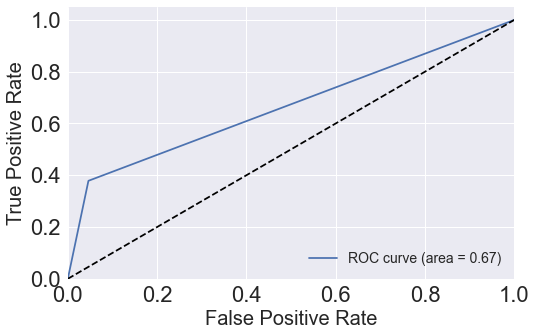

In [26]:
plt.figure(figsize=(8, 5))
plt.plot(fpr3, tpr3, label='ROC curve (area = %0.2f)' % (roc_auc3))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

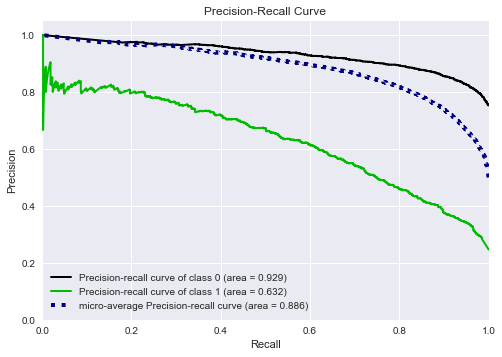

In [27]:
y_score = clf.predict_proba(X_test)

plot_precision_recall(y_test, y_score)
plt.show()

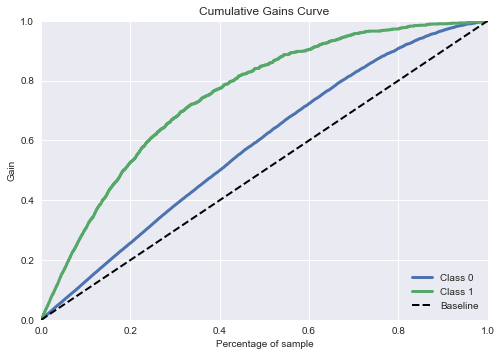

In [28]:
plot_cumulative_gain(y_test, y_score)
plt.show()

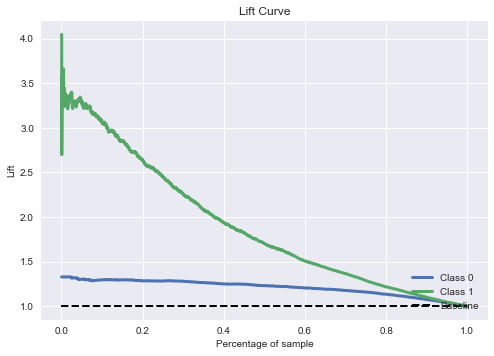

In [29]:
plot_lift_curve(y_test, y_score)
plt.show()

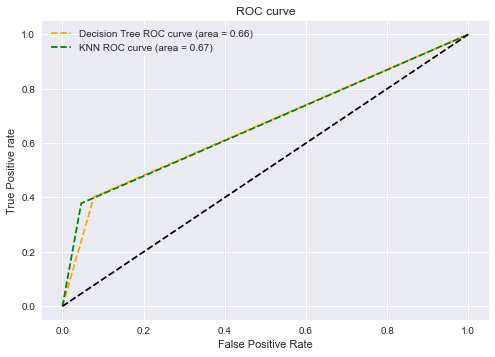

In [30]:
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Decision Tree ROC curve (area = %0.2f)' % (roc_auc1))
plt.plot(fpr3, tpr3, linestyle='--',color='green', label='KNN ROC curve (area = %0.2f)' % (roc_auc3))

plt.plot([0, 1], [0, 1], 'k--')

#plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title

plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()